In [1]:
import os
import time
import random
import math
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from PIL import Image
from IPython.display import clear_output

import ai2thor
import ai2thor_colab
from ai2thor_colab import plot_frames
from ai2thor.controller import Controller

from ai2thor.platform import CloudRendering
controller = Controller(platform=CloudRendering)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.distributions import Categorical

In [3]:
from network import DQN
from utils import to_torchdim, frame2tensor, plot_durations, encode_feedback_nav, encode_feedback_nav_for_pickup, encode_feedback_pickup, encode_feedback_drop

In [4]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## Set Environment

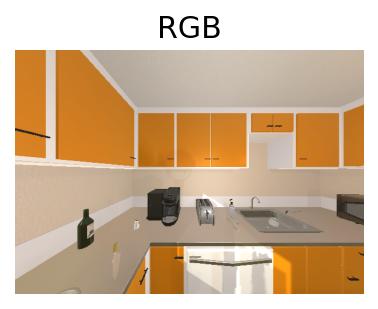

In [5]:
floor_index = random.randint(0, 30)
floor_index = 20

controller = Controller(
    agentMode = "default", # arm
    visibilityDistance = 0.50,
    scene = f"FloorPlan{floor_index}",

    # step sizes
    snapToGrid = True,
    gridSize = 0.25,
    rotateStepDegrees = 90,

    # image modalities
    renderInstanceSegmentation = False,
    renderDepthImage = False,
    renderSemanticSegmentation = False,
    renderNormalsImage = False,
    
    # camera properties
    width = 600,
    height = 420,
    fieldOfView = 120,
    
    # set seed for reproducability
    seed = 90,
)

plot_frames(controller.last_event)

In [6]:
instructions = [("place the bowl on the table", "Bowl_89852f2b")]

## Set Configs

In [7]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [8]:
BUFFER_SIZE = int(1e4) # 2e4
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
NUM_EPISODES = 14000 # 6000
TARGET_UPDATE = 4 # 8

TAU = 1e-4 # 5e-5
LR = 5.0e-4 # the best for attention is so far 5.0e-4

SCREEN_WIDTH = SCREEN_HEIGHT = 64

In [9]:
action_space = ["MoveAhead", "RotateLeft", "RotateRight", "PickupObject", "DropHandObject"]

## Load Word2Vec

In [10]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [11]:
glove_input_file = 'weights/glove.6B.100d.txt'
word2vec_output_file = 'weights/glove.6B.100d.txt.word2vec'

glove2word2vec(glove_input_file, word2vec_output_file)
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [12]:
pretrained_embeddings = torch.FloatTensor(word2vec_model.vectors)

In [13]:
# add padding
word2vec_model.key_to_index['<PAD>'] = len(word2vec_model.key_to_index)

new_embedding_vector = np.zeros((1, 100))
new_embedding_vector = torch.tensor(new_embedding_vector, dtype=torch.float)
pretrained_embeddings = torch.cat((pretrained_embeddings, new_embedding_vector), dim=0)

## Set Replay Memory

In [14]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["visual_state", "text_state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
    
    def add(self, visual_state, text_state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(visual_state, text_state, action, reward, next_state, done))
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        visual_states = torch.from_numpy(np.vstack([exp.visual_state.cpu().numpy() for exp in experiences if exp is not None])).float()
        visual_states = visual_states.to(device)
        
        text_states = torch.from_numpy(np.vstack([exp.text_state.cpu().numpy() for exp in experiences if exp is not None])).float()
        text_states = text_states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action.cpu().numpy() for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward.cpu().numpy() for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state.cpu().numpy() for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (visual_states, text_states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        
        return len(self.memory)

## Build Model

In [15]:
class CrossModalAttention(nn.Module):
    
    def __init__(self, visual_feature_dim=512, textual_feature_dim=768):
        
        super(CrossModalAttention, self).__init__()
        
        self.visual_attention = nn.Linear(visual_feature_dim, textual_feature_dim)
        self.textual_attention = nn.Linear(textual_feature_dim, textual_feature_dim)

    def forward(self, visual_features, text_features):
        
        # Compute attention scores
        visual_attention_scores = self.visual_attention(visual_features)
        textual_attention_scores = self.textual_attention(text_features)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(visual_attention_scores + textual_attention_scores, dim=1)

        # Apply attention weights to textual features
        attended_text_features = attention_weights * text_features

        return attended_text_features

In [16]:
class VisualModel(nn.Module):
    
    def __init__(self, seed):
        
        super(VisualModel, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()
        
    def forward(self, x):
        
        return self.cnn(x)
    
    
class TextModel(nn.Module):
    
    def __init__(self, pretrained_embedding, hidden_dim, seed):
        
        super(TextModel, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=True)
        self.rnn = nn.LSTM(pretrained_embedding.shape[1], hidden_dim)
        
    
    def forward(self, x):
        
        x = x.long()
        
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = output.view(output.shape[0], -1)
        
        return output

In [17]:
class MultimodalDQN(nn.Module):
    
    def __init__(self, visual_model, text_model, attention, action_size, seed):
        
        super(MultimodalDQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.visual_model = visual_model
        self.text_model = text_model
        self.attention = attention
        
        # Define three fully connected layers
        self.fc1 = nn.Linear(1280, 256) # 256, 512, 1024
        self.fc2 = nn.Linear(256, action_size)
        
    def forward(self, visual_input, text_input):
        
        visual_features = self.visual_model(visual_input.to(device))
        text_features = self.text_model(text_input.to(device))
        
        # print("--- DEBUG")
        # print("visual_features:", visual_features.shape)
        # print("text_features:", text_features.shape)
        
        # Apply attention mechanism
        attended_text_features = self.attention(visual_features, text_features)
        
        # Concatenate visual and text features
        combined_features = torch.cat((visual_features, attended_text_features), dim=1)
        
        # Apply fully connected layers
        combined_features = F.relu(self.fc1(combined_features))
        q_values = self.fc2(combined_features)
        
        return q_values

## Build Agent

In [18]:
class DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, screen_width, screen_height, action_size, seed):
        """Init Agent’s models."""
        
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Multimodal DQN
        self.visual_model = VisualModel(seed=seed)
        self.text_model = TextModel(pretrained_embeddings, hidden_dim=64, seed=seed)
        self.attention = CrossModalAttention()
        
        self.dqn_net = MultimodalDQN(self.visual_model, self.text_model, self.attention, action_size, seed).to(device)
        self.target_net = MultimodalDQN(self.visual_model, self.text_model, self.attention, action_size, seed).to(device)
        self.optimizer = optim.RMSprop(self.dqn_net.parameters(), lr=LR, alpha=0.95, eps=0.01)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
    
    def memorize(self, visual_state, text_state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(visual_state, text_state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % TARGET_UPDATE
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
    
    def visual_preprocess(self, visual_state, screen_width, screen_height):
        """Preprocess input frame before passing into agent."""
        
        resized_screen = Image.fromarray(visual_state).resize((screen_width, screen_height))
        visual_state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)

        return visual_state
    
    def text_preprocess(self, instruction):
        """Preprocess instructions before passing into agent."""
        
        text_state = instruction
        
        longest_sentence_length = 12
        sentence_length = len(text_state)
        
        padding = longest_sentence_length - len(text_state.split())
        text_state = text_state + ''.join([' <PAD>' for _ in range(padding)])
        
        text_state = [word2vec_model.key_to_index[word] for word in text_state.split()]
        text_state = torch.tensor(text_state).long()
        text_state = text_state.unsqueeze(0)
        
        return text_state
    
    def act(self, visual_state, text_state, epsilon=0.):
        """Returns actions for given state as per current policy."""
        
        # epsilon-greedy action selection
        if random.random() > epsilon:
            self.dqn_net.eval()
            with torch.no_grad():
                action = self.dqn_net(visual_state, text_state).max(1)[1].view(1, 1)
            self.dqn_net.train()
            
        else:
            action = torch.tensor([[random.randrange(self.action_size)]], dtype=torch.long, device=device)
            
        return action
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        visual_states, text_states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states, text_states).detach()
        _, action_max = Qsa_next.max(1)
        
        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states, text_states).detach().gather(1, action_max.unsqueeze(1))
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(visual_states, text_states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_target, Q_expected)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.target_net, self.dqn_net, TAU)
    
    def soft_update(self, target_net, dqn_net, tau):
        """Soft update target network parameters."""
        
        for target_param, dqn_param in zip(target_net.parameters(), dqn_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)
    
    def randomize_agent(self, controller):

        positions = controller.step(
            action="GetReachablePositions"
        ).metadata["actionReturn"]

        position = random.choice(positions)
        controller.step(
            action="Teleport",
            position=position,
            rotation=dict(x=0, y=270, z=0),
            horizon=0,
            standing=True
        )
        
    def watch(self, controller, instruction, action_space, num_episodes=10):
        """Watch trained agent."""
        
        best_score = -np.inf
        
        data = [("switch", "LightSwitch_887b121a"), ("tomato", "Tomato_e65a6e2e"), ("garbage", "GarbageCan_d6916cf5")]
        object_dict = dict(data)

        for i_episode in range(1, num_episodes+1):

            # initialize the environment and state
            controller.reset(random=True)
            
            self.randomize_agent(controller)

            visual_state = agent.visual_preprocess(controller.last_event.frame, 
                                               screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT)
        
            instruction, AGENT_TARGET = instruction, object_dict[instruction]
            text_state = agent.text_preprocess(instruction)
            
            total_score = 0

            self.dqn_net.eval()
            
            for time_step in range(1, 50):
                
                clear_output(wait=True)
                
                # select an action using the trained dqn network
                with torch.no_grad():
                    action = self.dqn_net(visual_state, text_state).max(1)[1].view(1, 1)

                print(f"Time Step: {time_step}, Action: {action_space[action.item()]}")
                event = controller.step(action = action_space[action.item()])

                time.sleep(1.25)
                
                _, reward, done, _ = encode_feedback(event, controller, target_name=AGENT_TARGET)

                # observe a new state
                if not done:
                    screen = controller.last_event.frame
                    resized_screen = Image.fromarray(screen).resize((SCREEN_WIDTH, SCREEN_HEIGHT))

                    next_state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)
                else:
                    time.sleep(1.25)
                    next_state = None

                visual_state = next_state
                total_score += reward
                if done:
                    break

            if total_score > best_score: 
                best_score = total_score

            print(f'\rEpisode {i_episode}/{num_episodes}, Total Score: {total_score}, Best Score: {best_score}', end='') 

In [19]:
agent = DQNAgent(screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT, action_size=len(action_space), seed=90)

In [20]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {"Total": total_params, "Trainable": trainable_params}

param_counts = count_parameters(agent.dqn_net)
print(f"Total Parameters: {param_counts['Total']}")
print(f"Trainable Parameters: {param_counts['Trainable']}")

Total Parameters: 52532905
Trainable Parameters: 12532805


## Modify Taks

In [21]:
instructions = [("find a bowl take it then place it on the table", "Bowl_89852f2b")]

In [22]:
action_space = ["MoveAhead", "RotateLeft", "RotateRight", "PickupObject", "DropHandObject"]
action_size = len(action_space)

In [23]:
agent.dqn_net.load_state_dict(torch.load(f'./agents/AI2THOR_MM_RL_ATT_TASK4.pth'));
agent.target_net.load_state_dict(torch.load(f'./agents/AI2THOR_MM_RL_ATT_TASK4.pth'));

In [24]:
agent.action_size = action_size

agent.dqn_net.fc2 = nn.Linear(256, action_size); agent.dqn_net.to(device);
agent.target_net.fc2 = nn.Linear(256, action_size); agent.target_net.to(device);

## Train Agent

In [25]:
# define linear decay
def calculate_epsilon(episode):
    slope = (EPS_END - EPS_START) / NUM_EPISODES
    epsilon = EPS_START + slope * episode

    return max(epsilon, EPS_END)

In [26]:
def randomize_agent(controller):
    
    positions = controller.step(
        action="GetReachablePositions"
    ).metadata["actionReturn"]

    position = random.choice(positions)
    controller.step(
        action="Teleport",
        position=position,
        rotation=dict(x=0, y=270, z=0),
        horizon=0,
        standing=True
    )

In [27]:
def train_network(num_episodes, max_time):
    
    epsilon = EPS_START
    
    for i_episode in range(1, num_episodes+1):
        
        # initialize the environment and state
        controller.reset(random=True)
        
        randomize_agent(controller)
        is_first_visit = True
        
        visual_state = agent.visual_preprocess(controller.last_event.frame, 
                                               screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT)
        
        inst_tupple = instructions[i_episode % len(instructions)]
        instruction, AGENT_TARGET = inst_tupple
        text_state = agent.text_preprocess(instruction)
        
        total_score = 0
        
        for time_step in range(1, max_time+1):
            
            # select and perform an action using dqn network
            action = agent.act(visual_state, text_state, epsilon)
            scalar_action = action.item()
            
            if (scalar_action == 4):
                event = controller.step(action=action_space[scalar_action], forceAction=False)
                _, reward, done, _ = encode_feedback_drop(event, controller, target_name=AGENT_TARGET)
            elif (scalar_action == 3):
                event = controller.step(action = action_space[scalar_action], 
                                        objectId = "Bowl|+01.59|+00.90|-01.26", 
                                        forceAction=False, manualInteract=False)
                _, reward, done, _ = encode_feedback_pickup(event, controller, target_name=AGENT_TARGET)
            else:
                event = controller.step(action = action_space[scalar_action])
                    
                if is_first_visit:
                    _, reward, done, _ = encode_feedback_nav(event, controller, target_name=AGENT_TARGET)
                    
                    if reward == +10.0: 
                        is_first_visit = False
                else: 
                    _, reward, done, _ = encode_feedback_nav_for_pickup(event, controller)
            
            # time.sleep(1)
            
            total_score += reward
            reward = torch.tensor([reward], device=device)
            
            next_state = agent.visual_preprocess(controller.last_event.frame, 
                                                 screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT)
            
            agent.memorize(visual_state, text_state, action, reward, next_state, done)
            
            # move to the next state
            visual_state = next_state
             
            if done or time_step == max_time:
                plot_durations(total_score, i_episode, num_episodes, instruction, total_score, time_step)
                break
            
        epsilon = calculate_epsilon(i_episode)
        
    if not os.path.exists('./agents/'): os.makedirs('./agents/')
    torch.save(agent.dqn_net.state_dict(), f'./agents/AI2THOR_MM_RL_ATT_TASK5.pth')
    
    # print('Training completed.')
    plt.ioff()
    plt.show()

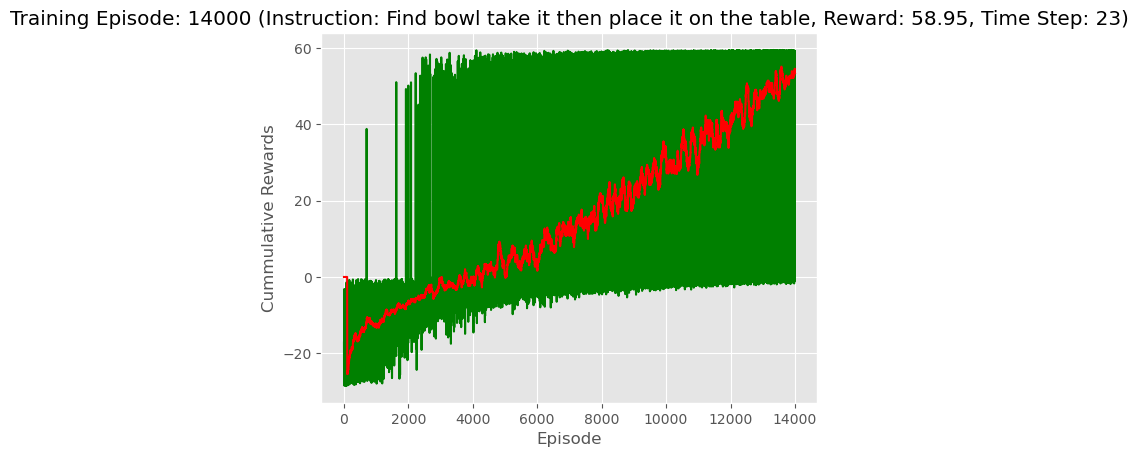

In [28]:
print('Training the network...')
train_network(num_episodes=NUM_EPISODES, max_time=400)

In [29]:
# 🚩 Chatgpt
# https://chat.openai.com/c/3faffdb2-8abe-4453-b501-357d27fa2c7a

# 1. define action ✅
# 2. modify neural network ✅
# 3. modify training process (agent's position, reward assignment) ✅
# 4. modify reward design ✅
# 5. check everything

---